In [1]:
##Khai báo các thư viện
from __future__ import print_function
import time
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, BatchNormalization,GRU
from keras.datasets import imdb

import os
from keras.preprocessing.text import Tokenizer


Using Theano backend.


In [2]:
## Gán nhãn cho dữ liệu train
X_train = []
y_train = []

path = 'C:/VS_8D/out/train/pos/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])

y_train.extend([1 for _ in range(735)])

path = 'C:/VS_8D/out/train/neg/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])

y_train.extend([0 for _ in range(333)])


In [3]:
##Gán nhãn cho dữ liệu test
X_test = []
y_test = []

path = 'C:/VS_8D/out/test/pos/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([1 for _ in range(338)])

path = 'C:/VS_8D/out/test/neg/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([0 for _ in range(119)])


In [4]:
## Xử lý remove stop words cho dữ liệu train
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

X_train_rm= []
stop_words=set(stopwords.words("vietnamese"))
for x in X_train:
    words=word_tokenize(x)
    remove_sw= [w for w in words if not unicode(w,"utf8") in stop_words]
    X_train_rm.append(remove_sw),
sentence_train=[] 
for i in range(len(X_train_rm)):
    s = ""
    for j in range(len(X_train_rm[i])):
        s+=X_train_rm[i][j]+" "
    sentence_train.append(s),


In [5]:
## Xử lý remove stop words cho dữ liệu test
X_test_rm= []
stop_words=set(stopwords.words("vietnamese"))
for x in X_test:
    words=word_tokenize(x)
    remove_sw= [w for w in words if not unicode(w,"utf8") in stop_words]

    X_test_rm.append(remove_sw),
sentence_test=[] 
for i in range(len(X_test_rm)):
    s = ""
    for j in range(len(X_test_rm[i])):
        s+=X_test_rm[i][j]+" "
    sentence_test.append(s),


In [6]:
print("Number of words: ")
print(len(np.unique(np.hstack(X_train ))))

Number of words: 
1065


Review length: 
Mean 5100.79 words (3807.761114)


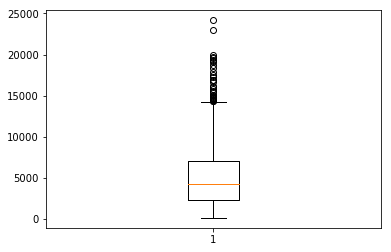

In [7]:
from matplotlib import pyplot
# Summarize review length
print("Review length: ")
result = map(len, X_train)
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

In [8]:
## Khai báo tham số đặc trưng và chiều dài câu
max_features =900
max_len = 200  # cut texts after this number of words (among top max_features most common words)

In [9]:
# Xứ lý tách từ 
imdbTokenizer = Tokenizer(nb_words=max_features)

imdbTokenizer.fit_on_texts(sentence_train)
#for word, value in imdbTokenizer.word_index.items():
    #print(word),


In [10]:
#create int to word dictionary
intToWord = {}
for word, value in imdbTokenizer.word_index.items():
    intToWord[value] = word

#add a symbol for null placeholder
intToWord[0] = "!!!NA!!!"
    
print(intToWord[1])
print(intToWord[2])
print(intToWord[32])


đồng
năm
án


In [11]:
#convert word strings to integer sequence lists
#print(X_train[0])
#print(imdbTokenizer.texts_to_sequences(X_train[:1]))
#for value in imdbTokenizer.texts_to_sequences(X_train[:1])[0]:
    #print(intToWord[value])
    
X_train = imdbTokenizer.texts_to_sequences(sentence_train)
X_test = imdbTokenizer.texts_to_sequences(sentence_test)


In [12]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)


1068 train sequences
457 test sequences
Pad sequences (samples x time)
X_train shape: (1068L, 200L)
X_test shape: (457L, 200L)


In [13]:
epochs = 1
embedding_neurons = 64
lstm_neurons = 128
batch_size =32


In [14]:
# Bi-directional Atom

# based on keras tutorial: https://github.com/fchollet/keras/blob/master/examples/imdb_bidirectional_lstm.py

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_atom = Model(input=sequence, output=output)
# review model structure
print(model_bidir_atom.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 200, 64)       57600       input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 200, 64)       256         embedding_1[0][0]                
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           74112       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [15]:
# Bi-directional Atom

# try using different optimizers and different optimizer configs
model_bidir_atom.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy','precision', 'recall', 'fmeasure'])

print('Train...')
start_time = time.time()

history_bidir_atom = model_bidir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)
scores = model_bidir_atom.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))



Train...
Train on 1068 samples, validate on 457 samples
Epoch 1/1
26s - loss: 0.6752 - acc: 0.6320 - precision: 0.7142 - recall: 0.7790 - fmeasure: 0.7392 - val_loss: 0.5961 - val_acc: 0.7396 - val_precision: 0.7396 - val_recall: 0.7702 - val_fmeasure: 0.7506
avg sec per epoch: 49.1490001678
Accuracy: 73.96%
